In [ ]:
!pip install -q transformers
!pip install -q transformers[onnx]
!pip install -q onnxruntime-gpu onnx psutil matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does n

In [ ]:
import onnx
import onnxruntime

onnx.__version__

'1.13.0'

# Exporting Transformer model to ONNX

In [ ]:
model_id = "vinai/phobert-base"

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# INPUT TEXT MUST BE ALREADY WORD-SEGMENTED!
sentence = 'Chúng_tôi là những nghiên_cứu_viên .'  

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
inputs = tokenizer(sentence, return_tensors="pt", return_token_type_ids=False)

In [ ]:
inputs

{'input_ids': tensor([[    0,   746,     8,    21, 46349,     5,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
inputs["input_ids"]

tensor([[    0,   746,     8,    21, 46349,     5,     2]])

In [ ]:
# Export the model
torch.onnx.export(phobert,              
                  (inputs["input_ids"], inputs["attention_mask"]),
                  "phobert.onnx", 
                  export_params=True,
                  opset_version=13,
                  do_constant_folding=True,
                  input_names = ["input_ids", "attention_mask"],
                  output_names = ['logits'],
                  dynamic_axes={'input_ids' : {0: 'batch_size',
                                               1: 'sentence_length'},    # variable length axes
                                'attention_mask': {0: 'batch_size',
                                                   1: 'sentence_length'},
                                'output' : {0 : 'batch_size'}})

/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:2016: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(


# Graph optimization

In [ ]:
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange
from typing import List
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties that might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_EXTENDED

  # Load the model as a graph and prepare the CPU backend 
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()
    
  return session


@contextmanager
def track_infer_time(buffer: List[int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: List[int] 
  optimized_model_path: str

In [ ]:
sentence = "Chúng_tôi là những nghiên_cứu_viên . Chúng_tôi là những học_sinh ."
# sentence = ["Chúng_tôi là những nghiên_cứu_viên .", "Chúng_tôi là những học_sinh ."]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)
cpu_model = create_model_for_provider("/content/phobert.onnx", "CPUExecutionProvider")

# Inputs are provided through numpy array
model_inputs = tokenizer(sentence, return_tensors="pt", return_token_type_ids=False)
onnx_inputs = tokenizer(sentence, return_tensors="np", return_token_type_ids=False)

# Run the model (None = get all the outputs)
outputs = cpu_model.run(output_names=["logits"], input_feed=dict(onnx_inputs))[0]

# Print information about outputs

print("Output shape: ", outputs.shape)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Output shape:  (1, 12, 768)


In [ ]:
cpu_model.get_inputs()[1].name

'attention_mask'

# Benchmarking PyTorch & ONNX

## Pytorch

In [ ]:
from collections import OrderedDict

PROVIDERS = [
    ("cpu", "PyTorch CPU"),
    ("cuda", "PyTorch GPU")
]

results = OrderedDict()

for device, label in PROVIDERS:
    
    # Move inputs to the correct device
    phobert.to(device)
    model_inputs_on_device = {
        arg_name: tensor.to(device)
        for arg_name, tensor in model_inputs.items()
    }

    # Add PyTorch to the providers
    for _ in trange(10, desc="Warming up"):
      phobert(**model_inputs_on_device)

    # Compute 
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
      with track_infer_time(time_buffer):
        phobert(**model_inputs_on_device)

    # Store the result
    results[label] = OnnxInferenceResult(
        time_buffer, 
        None
    ) 

cpu


Tracking inference time on PyTorch: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


cuda


Tracking inference time on PyTorch: 100%|██████████| 100/100 [00:01<00:00, 54.62it/s]


## ONNX

In [ ]:
PROVIDERS = [
    ("CPUExecutionProvider", "ONNX CPU"),
    ("CUDAExecutionProvider", "ONNX GPU")
]

for provider, label in PROVIDERS:
    # Create the model with the specified provider
    model = create_model_for_provider("/content/phobert.onnx", provider)

    # Keep track of the inference time
    time_buffer = []

    # Warm up the model
    model.run(output_names=["logits"], input_feed=dict(onnx_inputs))[0]

    # Compute 
    for _ in trange(100, desc=f"Tracking inference time on {provider}"):
      with track_infer_time(time_buffer):
          model.run(output_names=["logits"], input_feed=dict(onnx_inputs))[0]

    # Store the result
    results[label] = OnnxInferenceResult(
      time_buffer,
      model.get_session_options().optimized_model_filepath
    )

Tracking inference time on CUDAExecutionProvider: 100%|██████████| 100/100 [00:00<00:00, 215.51it/s]


## Compare

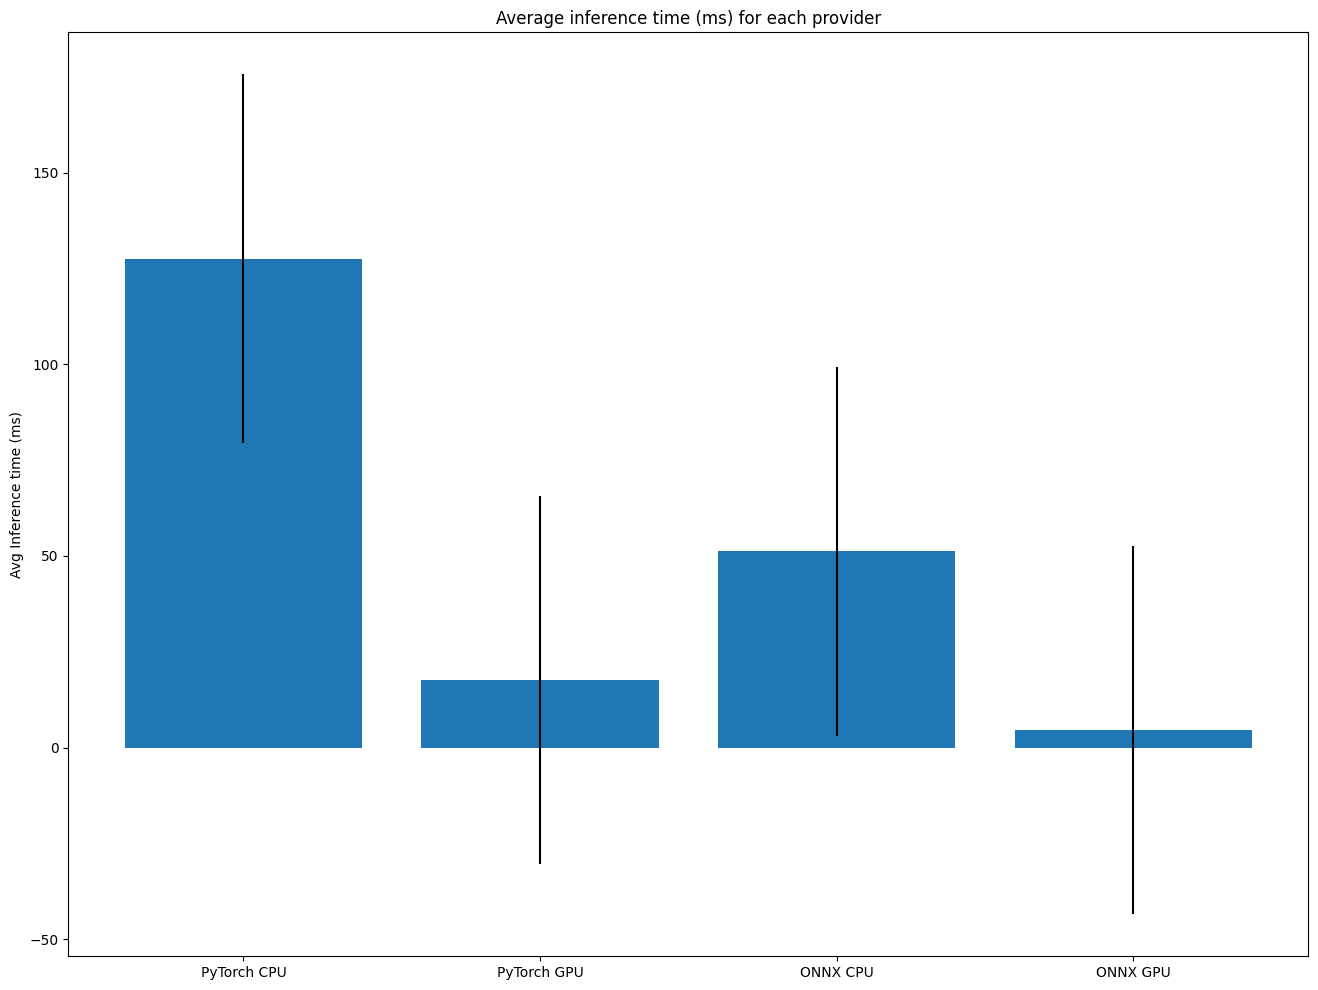

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()
     

In [ ]:
time_results

{'PyTorch CPU': 127.59579658508302,
 'PyTorch GPU': 17.58558988571167,
 'ONNX CPU': 51.21476888656616,
 'ONNX GPU': 4.5745110511779785}